# Using K_means algorithm to recognise color in image

This  Jupyter notebook "k_mean primary color.ipynb" is designed to perform color analysis on a set of images. 
It uses the k-means clustering algorithm to identify the primary colors in each image. 

## Import libraries

Necessary libraries. They are :
- `sklearn` for KMeans algorithm, 
- `matplotlib.pyplot` for plotting graphs, 
- `numpy` to work with arrays, 
- `cv2` to work with image data, 
- `collections` to use Counter to count values, 
- `rgb2lab` to convert RGB values and 
- `deltaE_cie76` to calculate similarity between colors.

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os

## Load the image 

Import one image in jpg form

The type of this input is <class 'numpy.ndarray'>
Shape: (671, 1024, 3)


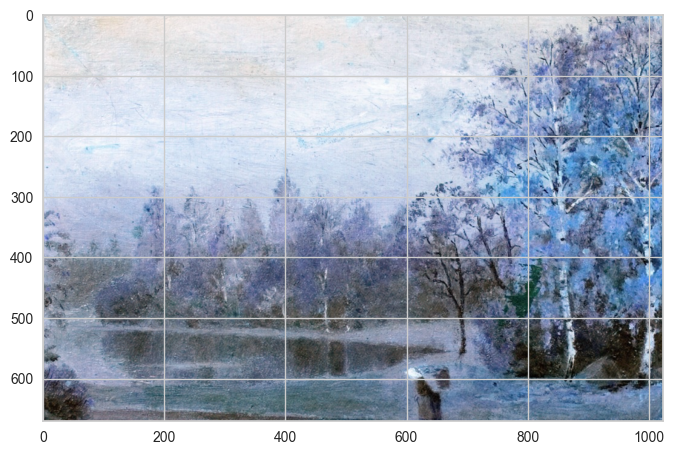

In [17]:
image = cv2.imread('images_jpg\8.jpg')
if image is None:
    print("Failed to load image")
else:
    print("The type of this input is {}".format(type(image)))
    print("Shape: {}".format(image.shape))
    plt.imshow(image)

### Note
The image appears to have altered colors when compared to the original. This discrepancy arises because OpenCV, by default, processes images in the BLUE GREEN RED (BGR) color sequence. Therefore, we need to adjust this to the RED GREEN BLUE (RGB) sequence to maintain the original color representation.

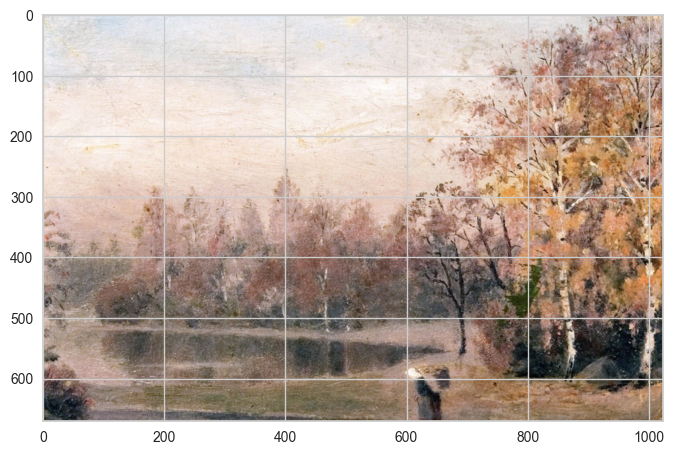

In [18]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

### Note
In cases where we are dealing with large images or multiple images of varying dimensions, it may be beneficial to resize the images to a consistent size.

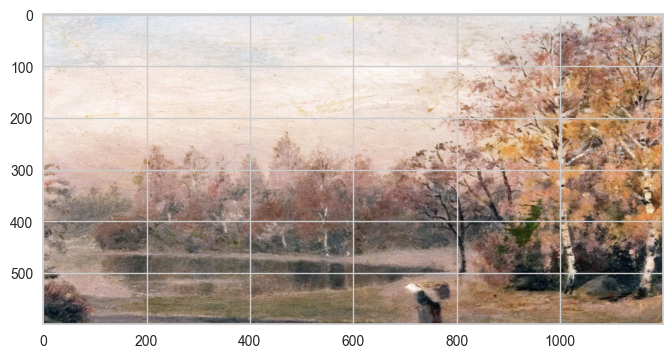

In [19]:
resized_image = cv2.resize(image, (1200, 600))
plt.imshow(resized_image)

## Color Identification (1 primary color)

I use this function in order to take the `hex` values of the colors that I will identify.

In [20]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def load_image(image_path) : reads an image from the provided path and converts it from BGR -> RGB color space

In [21]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

### Note
I will plot the data points in 3D space using python matplotlib in order to see the pixels how they are in the space

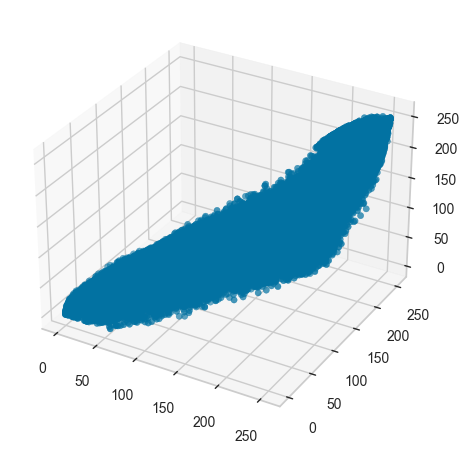

In [22]:
%matplotlib inline

#get rgb values from image to 1D array
r, g, b = cv2.split(image)
r = r.flatten()
g = g.flatten()
b = b.flatten()

#plotting 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(r, g, b)
plt.show()

### Run Kmean algorithm , number of clusters according to <u>the number of dominant colors that we want</u> ( 1st option)
#### extract_colors(image, number_of_colors, show_chart): does the main work of color extraction.

In [24]:
def extract_colors(image, number_of_colors, show_chart):
    
    # resize the image to speed up processing time
    #interpolation is a method to reduce the size of the image while keeping the quality good
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    # change the shape of the image, before it was 3D array(height, width, color channels), now it is 2D array(number of pixels, color channels)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    # create the model
    clf = KMeans(n_clusters = number_of_colors, n_init=10) # n_init is the number of times the KMeans algorithm will run with different centroid seeds, the best result will be chosen
    labels = clf.fit_predict(modified_image) # fit the model to the image data and predicts the cluster for each pixel
    # more specifcally, if we have 3 clusters, the labels will be 0, 1, 2, and each pixel will be assigned to one of these clusters, so if a particular pixel has label 0, it means it belongs to the first cluster
    
    counts = Counter(labels) # counts the number of pixels in each cluster
    counts = dict(sorted(counts.items())) # sort to ensure correct color percentage
    
    # get the cluster centers - or centroids
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()] # orders the colors according to the sorted keys of the counts dictionary
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()] # converts the RGB colors to HEX
    rgb_colors = [ordered_colors[i] for i in counts.keys()] # gets the RGB colors

    # show the chart
    if (show_chart):
        plt.figure(figsize = (8, 6)) # set the size of the chart
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors) # create the pie chart
    
    return np.array(rgb_colors) ,labels,modified_image

### Call the function with the number of dominant colors that you want to appeared

(array([[253.92475884, 236.70418006, 175.82797428],
        [233.23280098,  33.57739558,  67.39189189],
        [199.96876712, 191.1709589 ,  50.83342466],
        [163.52706553, 210.8974359 , 154.95156695],
        [240.21839646,  99.09837678,  69.86866699]]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([[255, 239, 177],
        [255, 239, 177],
        [255, 239, 177],
        ...,
        [255, 237, 175],
        [255, 237, 175],
        [255, 237, 175]], dtype=uint8))

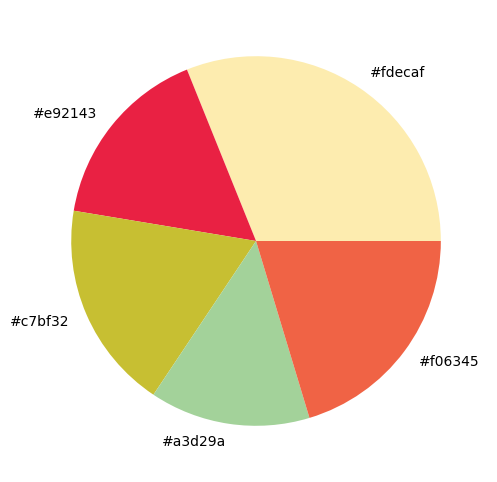

In [9]:
extract_colors(load_image('images_jpg\\colors.jpg'), 5, True)

### New Plot with the Colors - 1st Option

In [10]:
def visualize_clusters(image, labels, colors):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(colors)):
        cluster_pixels = image[labels == i]
        ax.scatter(cluster_pixels[:,0], cluster_pixels[:,1], cluster_pixels[:,2], 
                   c=RGB2HEX(colors[i]), s=40, label=f"C{i+1}")

    ax.scatter(colors[:,0], colors[:,1], colors[:,2], 
               c="black", s=150, label="Centroids", alpha=1)

    ax.set_title("K-means Clustering on Image")
    plt.legend()
    plt.show()

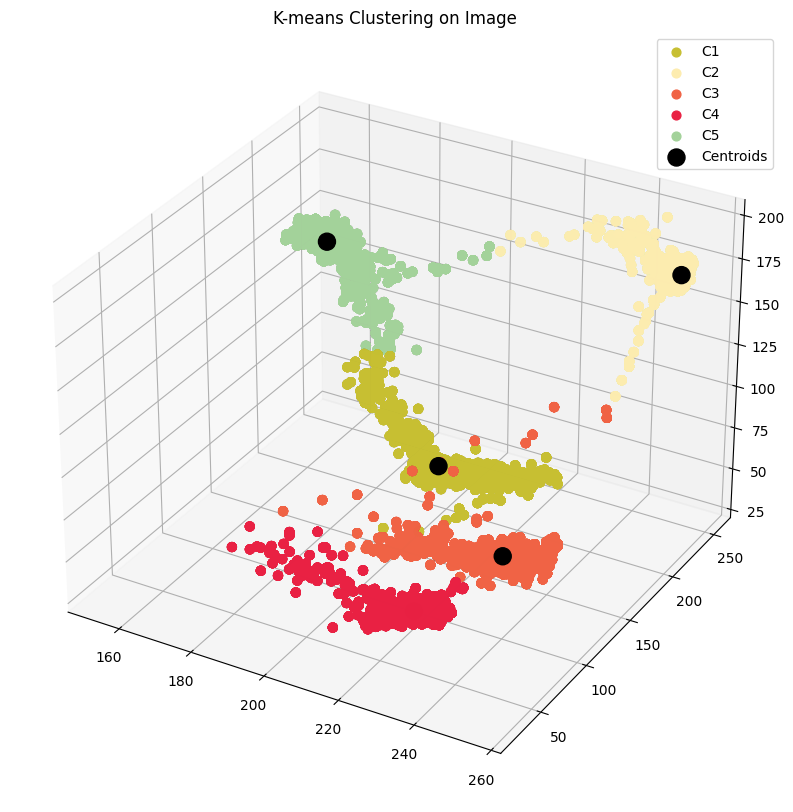

In [11]:
# Extract the dominant colors and their corresponding labels
rgb_colors, labels, modified_image = extract_colors(load_image('images_jpg\\colors.jpg'), 5, False)
# Visualize the clusters
visualize_clusters(modified_image, labels, rgb_colors)

### Show which color is most effective 
it means which clusters has the most data points 

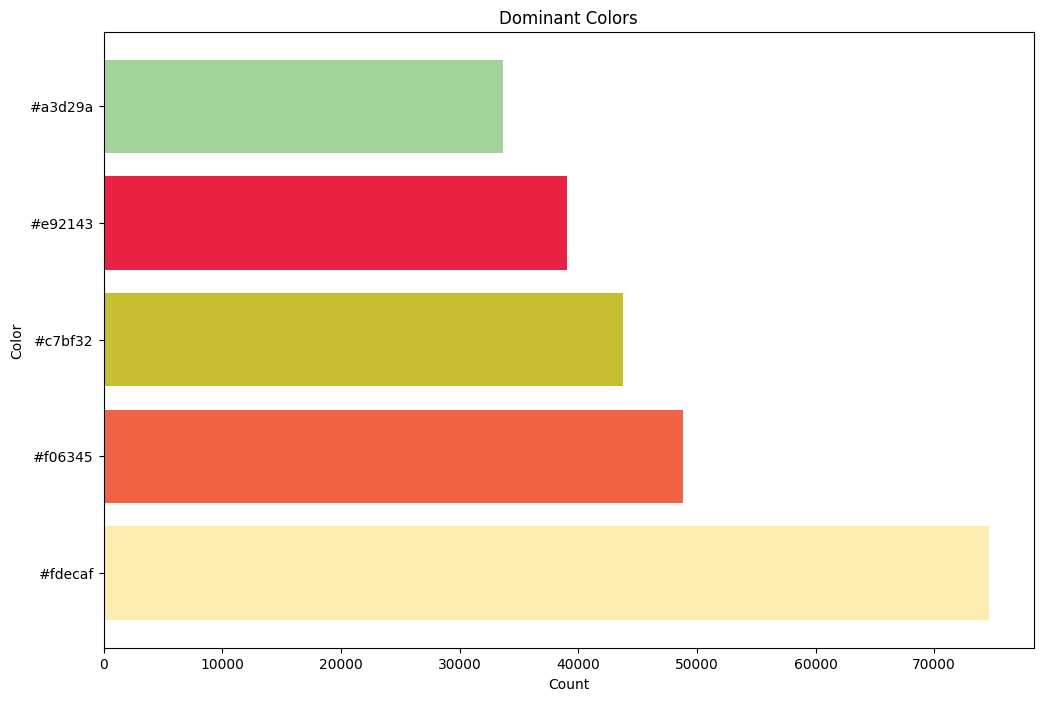

In [12]:
def display_dominant_colors(counts, hex_colors):
    # sort the counts dictionary in descending order
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

    # create lists for colors and their counts
    dominant_colors = [hex_colors[i] for i in sorted_counts.keys()]
    counts = list(sorted_counts.values())

    # create a bar chart
    plt.figure(figsize=(12, 8))
    plt.barh(dominant_colors, counts, color=dominant_colors)
    plt.xlabel('Count')
    plt.ylabel('Color')
    plt.title('Dominant Colors')
    plt.show()
    
# Count labels
counts = Counter(labels)

# Convert RGB colors to HEX
hex_colors = [RGB2HEX(rgb_color) for rgb_color in rgb_colors]

# Display dominant colors
display_dominant_colors(counts, hex_colors)

### Run Kmean algorithm using <u>the Elbow method</u> to find the number of clusters ( 2nd option)
#### extract_colors_elbow(image, show_chart):

In [25]:
from kneed import KneeLocator # to find the elbow point in the elbow method

def extract_colors_elbow(image, show_chart):
    # resize and reshape the image as before
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3) # reshape the image to 2D array ( where each row is a pixel and each column is 
    # a color channel RGB ) to be able to use it in the elbow method to find the optimal number of clusters

    # use the elbow method to find the optimal number of clusters
    distortions = [] # to store the distortions - the sum of the squared distances between each member of the cluster and its centroid
    K = range(1,10) # the range of the number of clusters - OPTIMAL NUMBER
    for k in K: # for each number of clusters
        kmeanModel = KMeans(n_clusters=k, n_init=10) # create the model
        kmeanModel.fit(modified_image) # fit the model to the image data
        distortions.append(kmeanModel.inertia_) # append the distortion to the list

    # plot the elbow
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-') # plot the number of clusters vs the distortions
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

    # find the elbow point
    kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
    number_of_colors = kn.knee # get the optimal number of clusters
    
    # Print the optimal number of clusters
    print(f'The optimal number of clusters is {number_of_colors}')

    # create the model with the optimal number of clusters
    clf = KMeans(n_clusters = number_of_colors, n_init=10)
    labels = clf.fit_predict(modified_image) # fit the model to the image data and predicts the cluster for each pixel

    counts = Counter(labels) # counts the number of pixels in each cluster
    counts = dict(sorted(counts.items())) # sort the counts by cluster number

    center_colors = clf.cluster_centers_ # get the cluster centers- the center color of each cluster
    ordered_colors = [center_colors[i] for i in counts.keys()] # orders the colors according to the sorted keys of the counts dictionary
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()] # converts the RGB colors to HEX
    rgb_colors = [ordered_colors[i] for i in counts.keys()] # gets the RGB colors

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)

    return np.array(rgb_colors) ,labels,modified_image

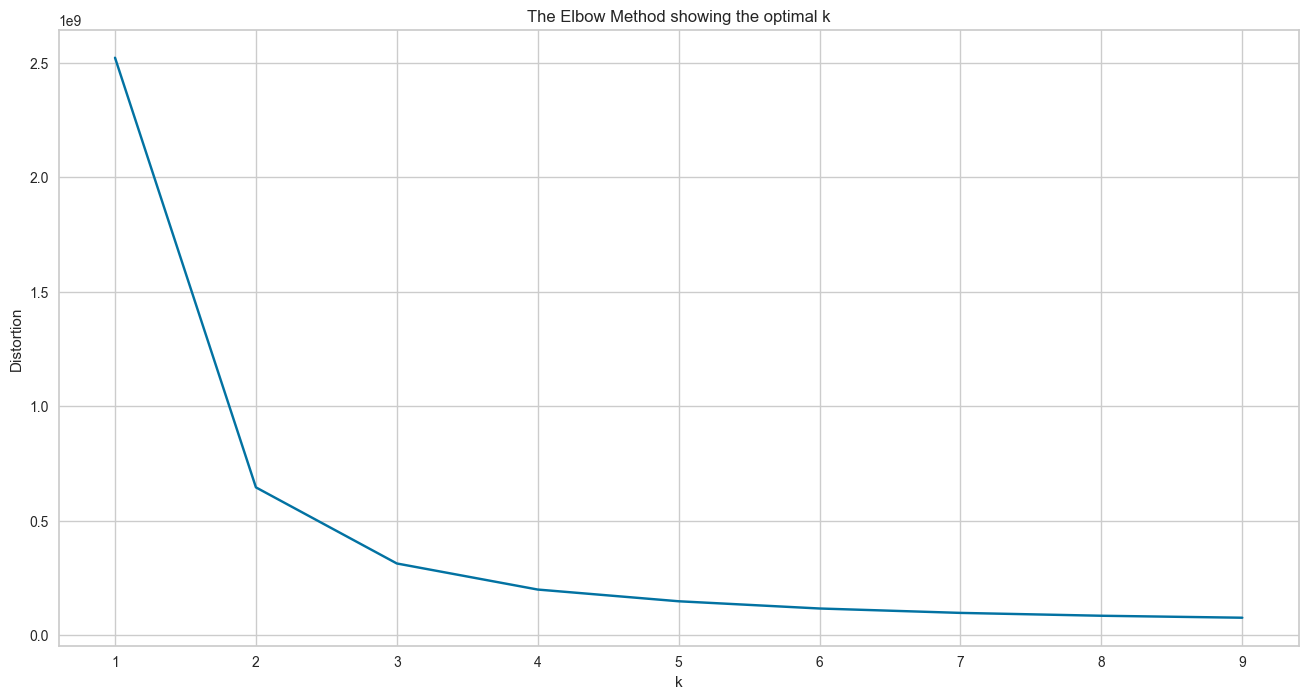

The optimal number of clusters is 3


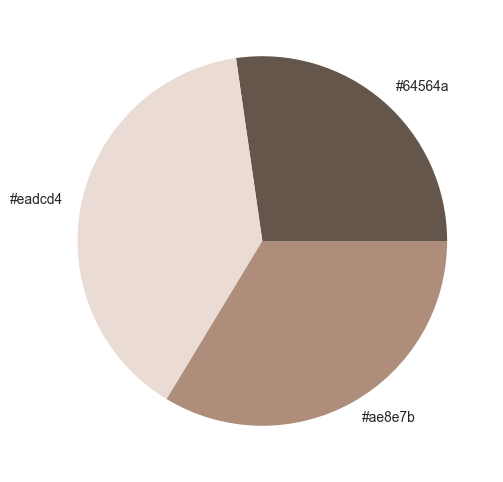

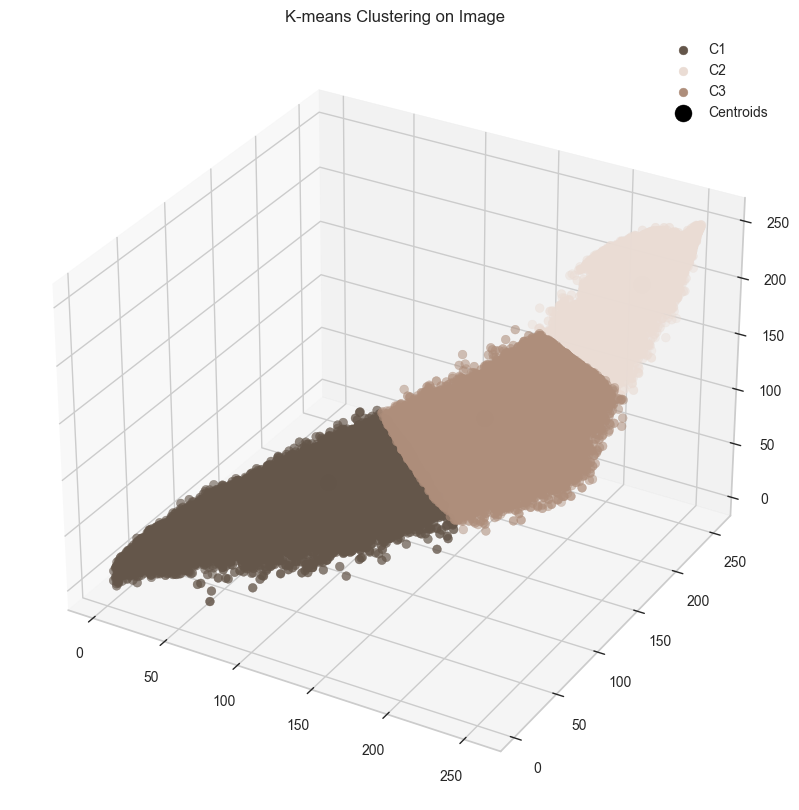

In [29]:
# Extract the dominant colors and their corresponding labels
rgb_colors, labels, modified_image = extract_colors_elbow(load_image('images_jpg\8.jpg'), True)
# Visualize the clusters
visualize_clusters(modified_image, labels, rgb_colors)

### Run Kmean algorithm using <u>the Silhouetter method</u> to find the number of clusters ( 3rd option)
#### extract_colors_silhouette(image, show_chart):

In [15]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

def extract_colors_silhouette(image, show_chart):
    # resize and reshape the image as before
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)

    # use the silhouette method to find the optimal number of clusters
    range_n_clusters = [2, 3, 4, 5]
    silhouette_avg = []

    for num_clusters in range_n_clusters:
        # initialise kmeans
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(modified_image)
        cluster_labels = kmeans.labels_

        # silhouette score
        silhouette_avg.append(silhouette_score(modified_image, cluster_labels))

    # plot silhouette scores
    plt.plot(range_n_clusters, silhouette_avg, 'bx-')
    plt.xlabel('Values of K') 
    plt.ylabel('Silhouette score') 
    plt.title('Silhouette analysis For Optimal k')
    plt.show()

    # find the optimal number of clusters
    optimal_k = range_n_clusters[silhouette_avg.index(max(silhouette_avg))] # get the optimal number of clusters

    # Print the optimal number of clusters
    print(f'The optimal number of clusters is {optimal_k}')

    # create the model with the optimal number of clusters
    clf = KMeans(n_clusters = optimal_k, n_init=10)
    labels = clf.fit_predict(modified_image) # fit the model to the image data and predicts the cluster for each pixel

    counts = Counter(labels) # counts the number of pixels in each cluster
    counts = dict(sorted(counts.items())) # sort the counts by cluster number

    center_colors = clf.cluster_centers_ # get the cluster centers- the center color of each cluster
    ordered_colors = [center_colors[i] for i in counts.keys()] # orders the colors according to the sorted keys of the counts dictionary
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()] # converts the RGB colors to HEX
    rgb_colors = [ordered_colors[i] for i in counts.keys()] # gets the RGB colors

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)

    return rgb_colors, labels

In [16]:
extract_colors_silhouette(load_image('images_jpg\\colors.jpg'), True)

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyboardInterrupt: 

### Run Kmean algorithm using <u>the Gap statistic</u> to find the number of clusters ( 4th option)
#### calculate_gap_statistic(image_path, nrefs=3, maxClusters=20)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
import pandas as pd

def optimalK(data, nrefs=3, maxClusters=15):
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame()
    for gap_index, k in enumerate(range(1, maxClusters)):
        refDisps = np.zeros(nrefs)
        for i in range(nrefs):
            randomReference = np.random.random_sample(size=data.shape)
            km = KMeans(k)
            km.fit(randomReference)
            refDisp = km.inertia_
            refDisps[i] = refDisp

        km = KMeans(k)
        km.fit(data)
        origDisp = km.inertia_
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        gaps[gap_index] = gap
        tempdf = pd.DataFrame({'clusterCount': [k], 'gap': [gap]})
        resultsdf = pd.concat([resultsdf, tempdf], ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)

def extract_colors_gap_statistic(image, show_chart):
    # Load the image from the file
    image = load_image(image)

    # Check if the image was correctly loaded
    if image is None:
        raise FileNotFoundError(f"No image found at {image}")
    
    # resize and reshape the image as before
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)

    # Use Gap Statistic to find optimal number of clusters
    optimal_k, df = optimalK(modified_image, nrefs=5, maxClusters=30)
    print('Optimal k is: ', optimal_k)

    # Plot Gap Statistic
    plt.figure(figsize=(16,8))
    plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b')
    plt.xlabel('k')
    plt.ylabel('Gap Statistic')
    plt.title('Gap Statistic vs. K')
    plt.show()

    # create the model with the optimal number of clusters
    clf = KMeans(n_clusters = optimal_k, n_init=10)
    labels = clf.fit_predict(modified_image) # fit the model to the image data and predicts the cluster for each pixel

    counts = Counter(labels) # counts the number of pixels in each cluster
    counts = dict(sorted(counts.items())) # sort the counts by cluster number

    center_colors = clf.cluster_centers_ # get the cluster centers- the center color of each cluster
    ordered_colors = [center_colors[i] for i in counts.keys()] # orders the colors according to the sorted keys of the counts dictionary
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()] # converts the RGB colors to HEX
    rgb_colors = [ordered_colors[i] for i in counts.keys()] # gets the RGB colors

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)

    return np.array(rgb_colors) ,labels,modified_image

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_in

Optimal k is:  29


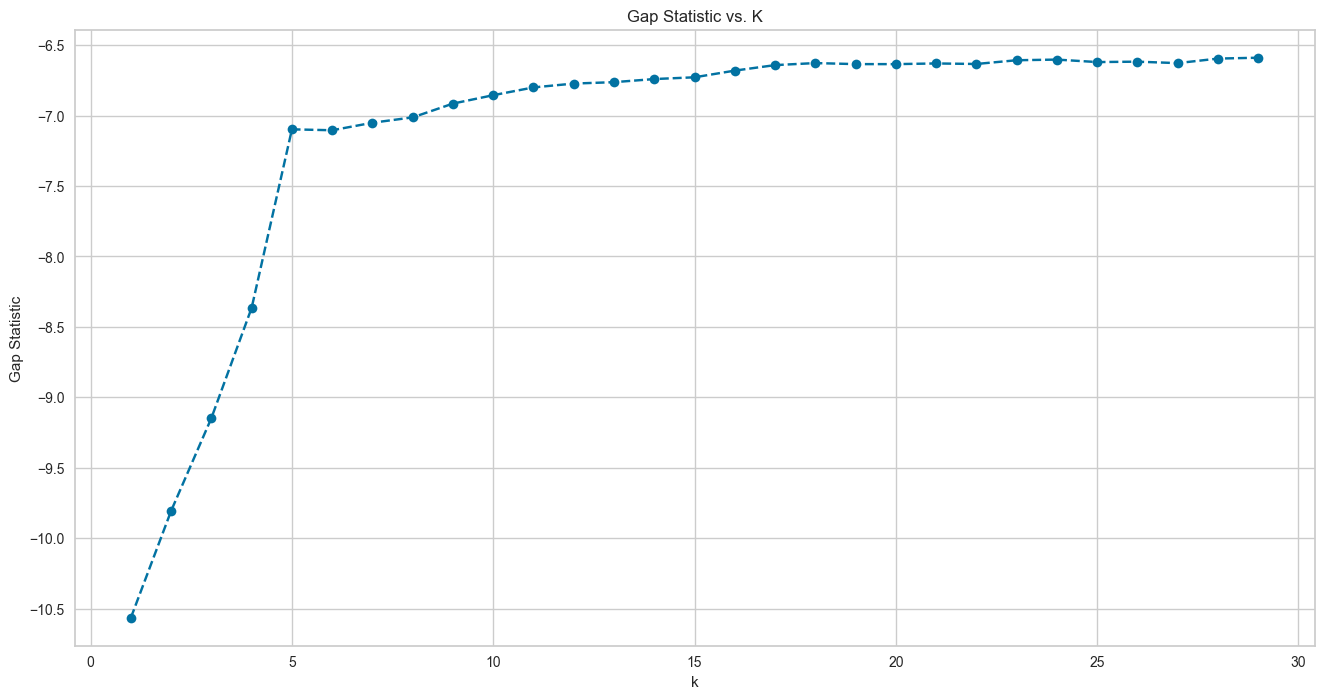

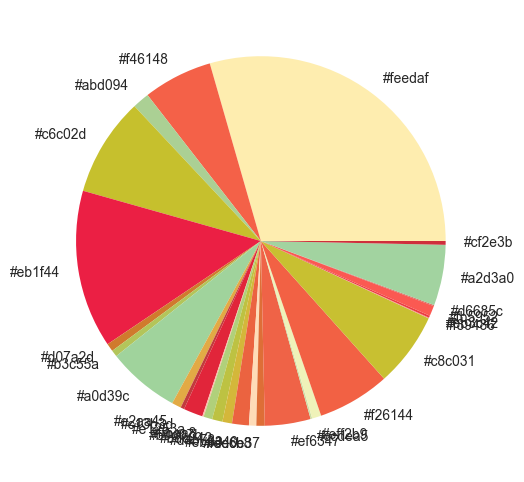

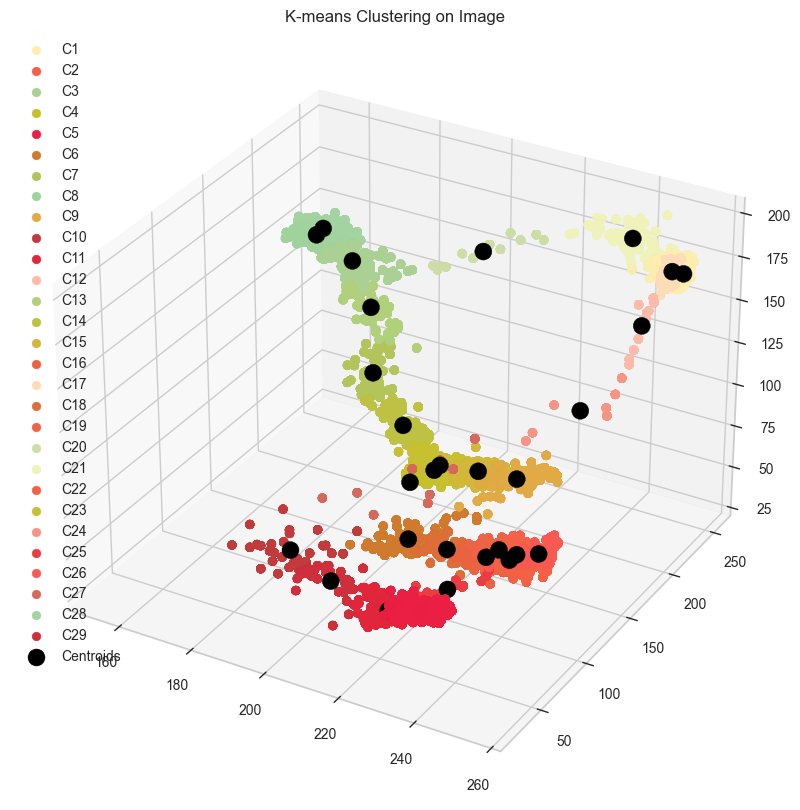

In [ ]:
# Extract colors using the function
rgb_colors, labels, modified_image = extract_colors_gap_statistic('images_jpg\\colors.jpg', True)

# # Reshape the labels to the original image shape
# labels = labels.reshape(modified_image.shape[0], modified_image.shape[1])

# Visualize the clusters
visualize_clusters(modified_image, labels, rgb_colors)

### Find colors names from the json file according to hex code values that we have found from the extraction and if some values don't have names then handling this option by finding the closest color name from the json file

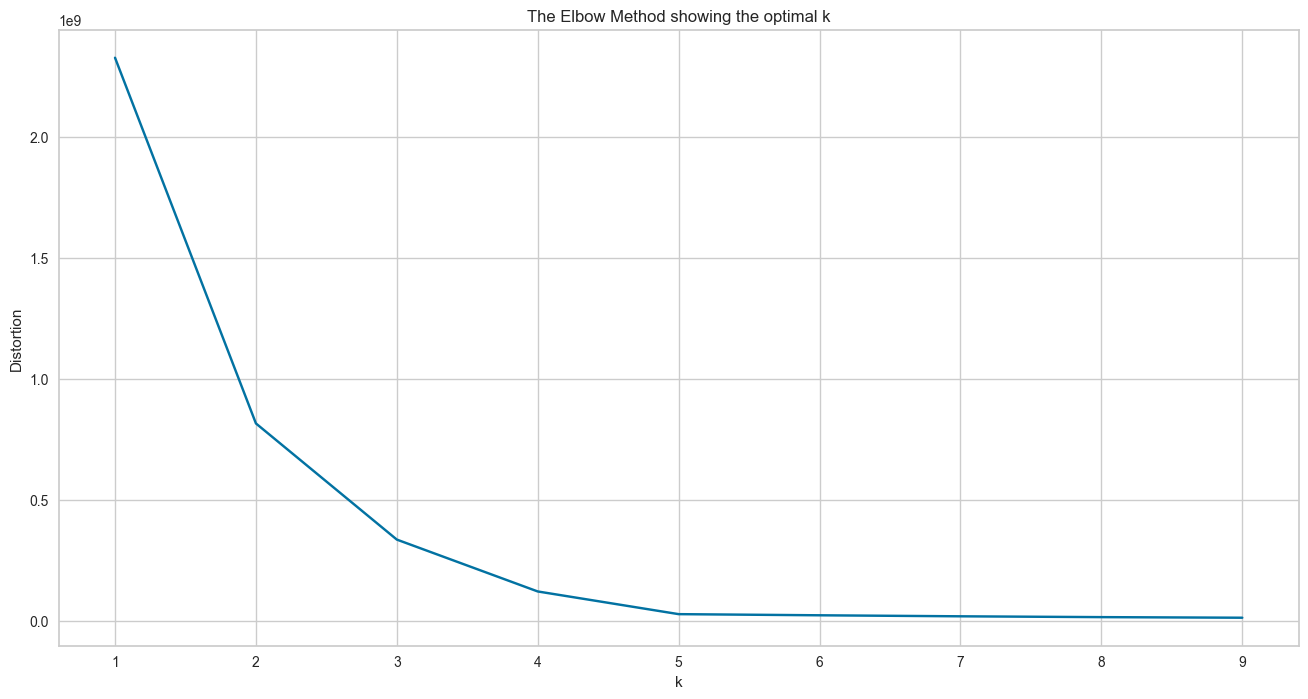

The optimal number of clusters is 3


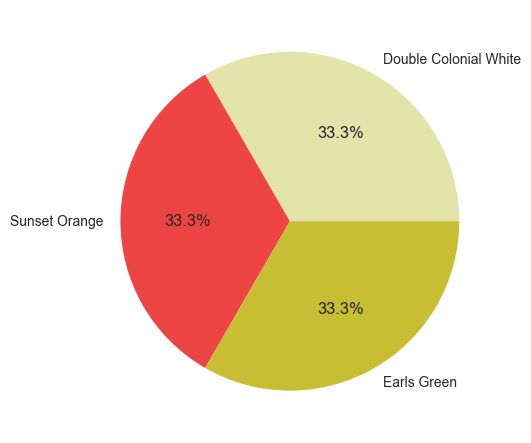

Color names for each hex code:
Hex code: #e2e4a9, Color name: Double Colonial White
Hex code: #ed4544, Color name: Sunset Orange
Hex code: #c7be33, Color name: Earls Green


In [ ]:
import matplotlib.pyplot as plt
import webcolors
import math
import json

# load color data from a JSON file
with open('colors_name.json') as json_file:
    json_data = json.load(json_file)

# Function to get the closest color name , calculate  the Euclidean distance between the requested color and each color in the JSON data, 
# and returns the name of the color with the smallest distance.
def closest_colour(requested_colour):
    min_colors = {}
    for key, name in json_data.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb("#"+key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colors[math.sqrt(rd + gd + bd)] = name
    return min_colors[min(min_colors.keys())]

# This function tries to get the color name directly from the JSON data. If the color is not in the JSON data, it calculates the closest color.
def get_colour_name(requested_hex):
    try:
        closest_name = actual_name = json_data[requested_hex]
    except KeyError:
        # Convert hex to RGB for closest color calculation
        requested_colour = webcolors.hex_to_rgb(requested_hex)
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

# This function creates a pie chart where each slice represents a color. The labels of the slices are the color names.
def plot_color_names_pie_chart(hex_codes):
    labels = []
    for hex_value in hex_codes:
        actual_name, closest_name = get_colour_name(hex_value)
        if actual_name is None:
            if closest_name is None:
                labels.append("Sorry we couldn't find the color")
            else:
                labels.append(closest_name)
        else:
            labels.append(actual_name)

    fig, ax = plt.subplots()
    ax.pie([1]*len(hex_codes), labels=labels, colors=hex_codes, autopct='%1.1f%%')
    plt.show()

    return labels

# Extract colors from an image, convert them to hex, and plot a pie chart:
hex_colors, labels, _ = extract_colors_elbow(image, False)
hex_colors = [RGB2HEX(color) for color in hex_colors]
color_names = plot_color_names_pie_chart(hex_colors)

print("Color names for each hex code:")
for hex_color, color_name in zip(hex_colors, color_names):
    print(f"Hex code: {hex_color}, Color name: {color_name}")

### Closest colors from the positive_emotion_words.csv 
- We use a string similarity measure which is the Levenshtein distance, to find the closest color name from the csv file 
- It provides a way to compute the Levenshtein distance between two strings. The Levenshtein distance, also known as the edit distance, is a measure of the difference between two sequences

In [ ]:
import pandas as pd
from fuzzywuzzy import fuzz #uses the Levenshtein distance to calculate string similarity.

# Load the positive emotion words
positive_emotion_words = pd.read_csv('positive_emotion_words.csv')

# Assume that the column containing the words is named 'Color'
word_colors = positive_emotion_words['Color'].values

# For each color_name
for color_name in color_names:
    # If the color_name is not in the list of positive emotion words
    if color_name not in positive_emotion_words.values:
        # Calculate the Levenshtein distance to each color in word_colors
        distances = [fuzz.ratio(color_name, word_color) for word_color in word_colors]
        # Find the index of the closest color
        closest_color_index = distances.index(max(distances))
        closest_color_name = word_colors[closest_color_index]
        print(f"The color name {color_name} does not exist in the positive_emotion_words.csv file. \n The closest color to it is {closest_color_name}.")

The color name Double Colonial White does not exist in the positive_emotion_words.csv file. 
 The closest color to it is Antique white.
The color name Sunset Orange does not exist in the positive_emotion_words.csv file. 
 The closest color to it is Orange.
The color name Earls Green does not exist in the positive_emotion_words.csv file. 
 The closest color to it is Green.


In [ ]:
import pandas as pd
from fuzzywuzzy import fuzz

# Load the positive emotion words
negative_emotion_words = pd.read_csv('negative_emotion_words.csv')

# Assume that the column containing the words is named 'Color'
word_colors = positive_emotion_words['Color'].values

# For each color_name
for color_name in color_names:
    # If the color_name is not in the list of positive emotion words
    if color_name not in positive_emotion_words.values:
        # Calculate the Levenshtein distance to each color in word_colors
        distances = [fuzz.ratio(color_name, word_color) for word_color in word_colors]
        # Find the index of the closest color
        closest_color_index = distances.index(max(distances))
        closest_color_name = word_colors[closest_color_index]
        print(f"The color name {color_name} does not exist in the positive_emotion_words.csv file. \n The closest color to it is {closest_color_name}.")

The color name Double Colonial White does not exist in the positive_emotion_words.csv file. 
 The closest color to it is Antique white.
The color name Sunset Orange does not exist in the positive_emotion_words.csv file. 
 The closest color to it is Orange.
The color name Earls Green does not exist in the positive_emotion_words.csv file. 
 The closest color to it is Green.


## Conclusion

In this notebook, we used KMeans to extract majority colors from images. We then used the RGB Values of Colors to identify images from a collection that have that color in them.